In [55]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns

import time
import os
import wandb

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

from utils import (sum_channels_parallel, calculate_ws_ch_proton_model,
                   calculate_joint_ws_across_experts,
                   create_dir, save_scales, evaluate_router,
                   intensity_regularization, sdi_gan_regularization,
                   generate_and_save_images,
                   calculate_expert_distribution_loss,
                   regressor_loss, calculate_expert_utilization_entropy,
                   StratifiedBatchSampler, get_predictions_from_generator_results,
                   get_predictions_from_experts_results)

from models_pytorch import Generator, Discriminator, RouterNetwork, AuxReg
from utils_eval import (get_mean_std_from_expert_genrations, plot_proton_photonsum_histogreams_shared,
                        plot_proton_photonsum_histogreams, make_histograms)

print(torch.cuda.is_available())
print(torch.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.autograd.set_detect_anomaly(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True
1.13.1


# Load models pretrained on separate intervals

Expert 0 - 1-5 - https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/awfmcz8h
Expert 1 - 5-17 - https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/urymlykl
Expert 2 - 18-493 - https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/tny2iyck

Expert 0 - 1-5 - "experiments/SDI-GAN-REG-PROTON-1-5-0.1-0.001-0.001_0.0001_1e-05_13_09_2024_22_48_1_5_13_09_2024_22_48"
"C:\Users\PB\Documents\GithubRepos\Generative-DNN-for-Physics-Simulations-CERN\dynamic_neural_networks\pytorch\dynamic_router\experiments\experiments_single_models\SDI-GAN-REG-PROTON-1-5-0.1-0.001-0.001_0.0001_1e-05_13_09_2024_22_48_1_5_13_09_2024_22_48\models\gen_SDI-GAN-REG-PROTON-1-5-0.1-0.001-0.001_39.h5"
Expert 1 - 5-17 - "experiments/SDI-GAN-REG-PROTON-5-17-0.1-0.001-0.001_0.0001_1e-05_13_09_2024_23_21_5_17_13_09_2024_23_21"
Insufficient training no model was saved

Expert 2 - 18-493 - "experiments/SDI-GAN-REG-PROTON-18-0.1-1e-06-0.001_0.0001_1e-05_13_09_2024_22_47_18_493_13_09_2024_22_47"
"\\?\C:\Users\PB\Documents\GithubRepos\Generative-DNN-for-Physics-Simulations-CERN\dynamic_neural_networks\pytorch\dynamic_router\experiments\experiments_single_models\SDI-GAN-REG-PROTON-18-0.1-1e-06-0.001_0.0001_1e-05_13_09_2024_22_47_18_493_13_09_2024_22_47\models\gen_SDI-GAN-REG-PROTON-18-0.1-1e-06-0.001_78.h5"

Expert 0 intensity - 0.001
Expert 1 intensity - 0.001
Expert 2 intensity - 0.000001
all other strengths the same

Generate plots from the models


### Load data

In [56]:
############ Entire data ###############
data_cond = pd.read_pickle('C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\data\\data_cond_photonsum_proton_1_2312.pkl')
data = pd.read_pickle('C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\data\\data_proton_photonsum_proton_1_2312.pkl')
data = np.log(data + 1).astype(np.float32)

scaler_cond = StandardScaler()
data_cond_scaled = scaler_cond.fit_transform(data_cond.drop(columns=['expert_number', 'std_proton', 'group_number_proton', 'proton_photon_sum'])).astype(
    np.float32)

indices = np.arange(data_cond_scaled.shape[0])
_, x_test, _, y_test, _, idx_test = train_test_split(data, data_cond_scaled, indices, test_size=0.2, shuffle=False)
del data
print(f"WHOLE DATA: {x_test.shape}, {y_test.shape}, {idx_test.shape}")

# ############ EXPERT 0 ###############
# data_0 = pd.read_pickle('C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\data\\small_intervals\\data_photonsum_proton_1_5_neutron_0_3153.pkl')
# data_cond_0 = pd.read_pickle('C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\data\\small_intervals\\data_cond_photonsum_proton_1_5_neutron_0_3153.pkl')
# photon_sum_proton_min, photon_sum_proton_max = data_cond_0.proton_photon_sum.min(), data_cond_0.proton_photon_sum.max()
# print("EXPERT 0, Data_cond shape", data_cond_0.shape, photon_sum_proton_min, photon_sum_proton_max)
# data_0 = np.log(data_0 + 1).astype(np.float32)
# scaler_cond_0 = StandardScaler()
# data_cond_0_scaled = scaler_cond_0.fit_transform(data_cond_0.drop(columns=['proton_photon_sum', 'std', 'group_number'])).astype(
#     np.float32)
# _, x_test_0, _, y_test_0 = train_test_split(data_0, data_cond_0_scaled, test_size=0.2, shuffle=True)
# print("EXPERT 0, Data shapes after train_test_split:", x_test_0.shape, y_test_0.shape)
#
# ############ EXPERT 1 ###############
# data_1 = pd.read_pickle('C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\data\\small_intervals\\data_photonsum_proton_5_17_neutron_0_3360.pkl')
# data_cond_1 = pd.read_pickle('C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\data\\small_intervals\\data_cond_photonsum_proton_5_17_neutron_0_3360.pkl')
# photon_sum_proton_min, photon_sum_proton_max = data_cond_1.proton_photon_sum.min(), data_cond_1.proton_photon_sum.max()
# print("EXPERT 1, Data_cond shape", data_cond_1.shape, photon_sum_proton_min, photon_sum_proton_max)
# data_1 = np.log(data_1 + 1).astype(np.float32)
# scaler_cond_1 = StandardScaler()
# data_cond_1_scaled = scaler_cond_1.fit_transform(data_cond_1.drop(columns=['proton_photon_sum', 'std', 'group_number'])).astype(
#     np.float32)
# _, x_test_1, _, y_test_1 = train_test_split(data_1, data_cond_1_scaled, test_size=0.2, shuffle=True)
# print("EXPERT 1, Data shapes after train_test_split:", x_test_1.shape, y_test_1.shape)
#
# ############ EXPERT 2 ###############
# data_2 = pd.read_pickle('C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\data\\small_intervals\\data_photonsum_proton_18_493_neutron_0_3145.pkl')
# data_cond_2 = pd.read_pickle('C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\data\\small_intervals\\data_cond_photonsum_proton_18_493_neutron_0_3145.pkl')
# photon_sum_proton_min, photon_sum_proton_max = data_cond_2.proton_photon_sum.min(), data_cond_2.proton_photon_sum.max()
# print("EXPERT 2, Data_cond shape", data_cond_2.shape, photon_sum_proton_min, photon_sum_proton_max)
# data_2 = np.log(data_2 + 1).astype(np.float32)
# scaler_cond_2 = StandardScaler()
# data_cond_2_scaled = scaler_cond_2.fit_transform(data_cond_2.drop(columns=['proton_photon_sum', 'std', 'group_number'])).astype(
#     np.float32)
# _, x_test_2, _, y_test_2 = train_test_split(data_2, data_cond_2_scaled, test_size=0.2, shuffle=True)
# print("EXPERT 2, Data shapes after train_test_split:", x_test_2.shape, y_test_2.shape)

WHOLE DATA: (68846, 56, 30), (68846, 9), (68846,)


#### Load the quartile data

In [39]:
# Calculate quartiles and assign labels
d_temp = data_cond.proton_photon_sum
quartiles = pd.qcut(d_temp, q=4, labels=["1st Quartile", "2nd Quartile", "3rd Quartile", "4th Quartile"])

# Save the indices for each quartile
quartile_indices = {
    "1st Quartile": d_temp.index[quartiles == "1st Quartile"].tolist(),
    "2nd Quartile": d_temp.index[quartiles == "2nd Quartile"].tolist(),
    "3rd Quartile": d_temp.index[quartiles == "3rd Quartile"].tolist(),
    "4th Quartile": d_temp.index[quartiles == "4th Quartile"].tolist(),
}

In [40]:
quartile_1_y_test = []
quartile_2_y_test = []
quartile_3_y_test = []
quartile_4_y_test = []
for i, idx in enumerate(idx_test):
    if idx in quartile_indices["1st Quartile"]:
        quartile_1_y_test.append(i)
    elif idx in quartile_indices["2nd Quartile"]:
        quartile_2_y_test.append(i)
    elif idx in quartile_indices["3rd Quartile"]:
        quartile_3_y_test.append(i)
    elif idx in quartile_indices["4th Quartile"]:
        quartile_4_y_test.append(i)
    else:
        print("Index not found in any quartile")

In [41]:
quartile_1_x_test_data, quartile_1_y_test_data = x_test[quartile_1_y_test], y_test[quartile_1_y_test]
quartile_2_x_test_data, quartile_2_y_test_data = x_test[quartile_2_y_test], y_test[quartile_2_y_test]
quartile_3_x_test_data, quartile_3_y_test_data = x_test[quartile_3_y_test], y_test[quartile_3_y_test]
quartile_4_x_test_data, quartile_4_y_test_data = x_test[quartile_4_y_test], y_test[quartile_4_y_test]

In [42]:
org = np.exp(quartile_1_x_test_data) - 1
ch_org_quartile_1 = np.array(org).reshape(-1, 56, 30)
del org
ch_org_quartile_1 = pd.DataFrame(sum_channels_parallel(ch_org_quartile_1)).values

org = np.exp(quartile_2_x_test_data) - 1
ch_org_quartile_2 = np.array(org).reshape(-1, 56, 30)
del org
ch_org_quartile_2 = pd.DataFrame(sum_channels_parallel(ch_org_quartile_2)).values

org = np.exp(quartile_3_x_test_data) - 1
ch_org_quartile_3 = np.array(org).reshape(-1, 56, 30)
del org
ch_org_quartile_3 = pd.DataFrame(sum_channels_parallel(ch_org_quartile_3)).values

org = np.exp(quartile_4_x_test_data) - 1
ch_org_quartile_4 = np.array(org).reshape(-1, 56, 30)
del org
ch_org_quartile_4 = pd.DataFrame(sum_channels_parallel(ch_org_quartile_4)).values

#### Load models

In [ ]:
# NOISE_DIM = 10
# N_COND = 9

In [ ]:
# ############ EXPERT 0 ###############
# expert_0 = Generator(NOISE_DIM, N_COND).to(device)
# expert_0_weights = r"\\?\C:\Users\PB\Documents\GithubRepos\Generative-DNN-for-Physics-Simulations-CERN\dynamic_neural_networks\pytorch\dynamic_router\experiments\experiments_single_models\SDI-GAN-REG-PROTON-1-5-0.1-0.001-0.001_0.0001_1e-05_13_09_2024_22_48_1_5_13_09_2024_22_48\models\gen_SDI-GAN-REG-PROTON-1-5-0.1-0.001-0.001_39.h5"
# expert_0.load_state_dict(torch.load(expert_0_weights))
#
# ############ EXPERT 1 ###############
# expert_1 = Generator(NOISE_DIM, N_COND).to(device)
# expert_1_weights = r"C:\Users\PB\Documents\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXPERI~1\SDI-GA~4.000\models\GEFADD~1.H5"
# expert_1.load_state_dict(torch.load(expert_1_weights))
#
# ############ EXPERT 2 ###############
# expert_2 = Generator(NOISE_DIM, N_COND).to(device)
# expert_2_weights = r"\\?\C:\Users\PB\Documents\GithubRepos\Generative-DNN-for-Physics-Simulations-CERN\dynamic_neural_networks\pytorch\dynamic_router\experiments\experiments_single_models\SDI-GAN-REG-PROTON-18-0.1-1e-06-0.001_0.0001_1e-05_13_09_2024_22_47_18_493_13_09_2024_22_47\models\gen_SDI-GAN-REG-PROTON-18-0.1-1e-06-0.001_78.h5"
# expert_2.load_state_dict(torch.load(expert_2_weights))

#### Generate MEAN and STD of the experts on the test data

In [ ]:
############ EXPERT 0 ###############
noise_cond_0 = torch.tensor(y_test_0, device=device)
noise_0 = torch.randn(len(noise_cond_0), NOISE_DIM, device=device)
photonsum_mean_generated_images_0, photonsum_std_generated_images_0, photonsum_on_all_generated_images_0 = get_mean_std_from_expert_genrations(noise_cond_0, expert_0, device, batch_size=64, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_0, photonsum_std_generated_images_0

In [ ]:
############ EXPERT 0 ###############
noise_cond_1 = torch.tensor(y_test_1, device=device)
noise_1 = torch.randn(len(noise_cond_1), NOISE_DIM, device=device)
photonsum_mean_generated_images_1, photonsum_std_generated_images_1, photonsum_on_all_generated_images_1 = get_mean_std_from_expert_genrations(noise_cond_1, expert_1, device, batch_size=64, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_1, photonsum_std_generated_images_1

In [ ]:
############ EXPERT 2 ###############
noise_cond_2 = torch.tensor(y_test_2, device=device)
noise_2 = torch.randn(len(noise_cond_2), NOISE_DIM, device=device)
photonsum_mean_generated_images_2, photonsum_std_generated_images_2, photonsum_on_all_generated_images_2 = get_mean_std_from_expert_genrations(noise_cond_2, expert_2, device, batch_size=64, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_2, photonsum_std_generated_images_2

In [ ]:
fig = plot_proton_photonsum_histogreams_shared(photonsum_on_all_generated_images_0, photonsum_on_all_generated_images_1, photonsum_on_all_generated_images_2)
fig.show()

## Plot images of the experts on the test data

# Model based on routers

## Analyze routers

In [57]:
y_test_tensor = torch.tensor(y_test, requires_grad=False, device=device)

In [58]:
N_COND = 9
N_EXPERTS = 3
router_network = RouterNetwork(N_COND, N_EXPERTS).to(device)

# router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DI37B3~1.001\models\ROUTER~2.PTH"

# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/vkdr0b5p
# router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DID0AE~1.001\models\router_network_epoch_99.pth"
router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DID0AE~1.001\models\router_network_epoch_99.pth"

# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/q7ulqrki/workspace?nw=nwuserbedkowskipatrick - 1.29 WS but very bad histogram
# router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXA6DA~1\DI28F6~1.001\models\router_network_epoch_163.pth"
# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/cxzbusoj?nw=nwuserbedkowskipatrick
# router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DIE1D1~1.001\models\router_network_epoch_118.pth"
# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/r98v3gus
# # https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/r98v3gus?nw=nwuserbedkowskipatrick - histogram sucks
# router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX8E9A~1\DI4B10~1.001\models\router_network_epoch_92.pth"
# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/16ax5zi8?nw=nwuserbedkowskipatrick - bad histogram
# router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DI4B10~1.001\models\router_network_epoch_107.pth"
# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/kssnv4d3/overview bad histogram
# router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DI37B3~1.001\models\router_network_epoch_101.pth"

# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/16ax5zi8 - bad histogram and bad ws
# router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX5CCF~1\DI4B10~1.001\models\router_network_epoch_199.pth"

router_network.load_state_dict(torch.load(router_weights))

with torch.no_grad():
    router_network.eval()
    predicted_expert_one_hot = router_network(y_test_tensor).cpu().numpy()
    predicted_expert = np.argmax(predicted_expert_one_hot, axis=1)

In [59]:
expert_counts = np.unique(predicted_expert,  return_counts=True)
expert_number_count_dict = {expert_number: expert_count for (expert_number, expert_count) in zip(expert_counts[0], expert_counts[1])}
expert_number_count_dict

{1: 68454, 2: 392}

In [28]:
# # Assuming data_cond is your DataFrame and proton_photon_sum is a column in it
# data_cond.proton_photon_sum.hist(bins=30, alpha=0.7, color='blue')  # Adjust bins, alpha, and color as needed
#
# # Set the x and y axis to logarithmic scale
# plt.xscale('log')  # Set x-axis to logarithmic scale
# plt.yscale('log')  # Set y-axis to logarithmic scale

In [29]:
# data_cond_temp = data_cond.iloc[idx_test].reset_index(drop=True)

In [ ]:
# data_cond_0 = data_cond_temp.iloc[np.where(predicted_expert == 0)[0].tolist()]
# data_cond_1 = data_cond_temp.iloc[np.where(predicted_expert == 1)[0].tolist()]
# data_cond_2 = data_cond_temp.iloc[np.where(predicted_expert == 2)[0].tolist()]
# len(data_cond_0), len(data_cond_1), len(data_cond_2)

In [ ]:
# fig = plot_proton_photonsum_histogreams_shared(data_cond_0.proton_photon_sum, data_cond_1.proton_photon_sum, data_cond_2.proton_photon_sum)
# fig.show()

In [ ]:
# fig = plot_proton_photonsum_histogreams(data_cond_0.proton_photon_sum, data_cond_1.proton_photon_sum, data_cond_2.proton_photon_sum)
# fig.show()

In [ ]:
# data_cond_0.proton_photon_sum.mean(), data_cond_1.proton_photon_sum.mean(), data_cond_2.proton_photon_sum.mean()

### Load models of experts

In [60]:
NOISE_DIM = 10
N_COND = 9

In [61]:
DI_STRENGTH, IN_STRENGTH = 0.1, 0.0001

# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/16ax5zi8 - bad histogram and bad ws
############ EXPERT 0 ###############
# expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX5CCF~1\DI4B10~1.001\models\gen_0_199.h5"
# expert_0.load_state_dict(torch.load(expert_0_weights))
#
# ############ EXPERT 1 ###############
# expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX5CCF~1\DI4B10~1.001\models\gen_1_199.h5"
# expert_1.load_state_dict(torch.load(expert_1_weights))
#
# ############ EXPERT 2 ###############
# expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX5CCF~1\DI4B10~1.001\models\gen_2_199.h5"
# expert_2.load_state_dict(torch.load(expert_2_weights))

# # https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/kssnv4d3 - bad histogram
# ############ EXPERT 0 ###############
# expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DI37B3~1.001\models\gen_0_101.h5"
# expert_0.load_state_dict(torch.load(expert_0_weights))
#
# ############ EXPERT 1 ###############
# expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DI37B3~1.001\models\gen_1_101.h5"
# expert_1.load_state_dict(torch.load(expert_1_weights))
#
# ############ EXPERT 2 ###############
# expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DI37B3~1.001\models\gen_2_101.h5"
# expert_2.load_state_dict(torch.load(expert_2_weights))

# # https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/16ax5zi8 - bad histogram
# ############ EXPERT 0 ###############
# expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DI4B10~1.001\models\gen_0_107.h5"
# expert_0.load_state_dict(torch.load(expert_0_weights))
#
# ############ EXPERT 1 ###############
# expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DI4B10~1.001\models\gen_1_107.h5"
# expert_1.load_state_dict(torch.load(expert_1_weights))
#
# ############ EXPERT 2 ###############
# expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DI4B10~1.001\models\gen_2_107.h5"
# expert_2.load_state_dict(torch.load(expert_2_weights))

# # https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/r98v3gus?nw=nwuserbedkowskipatrick - histogram sucks
# ############ EXPERT 0 ###############
# expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX8E9A~1\DI4B10~1.001\models\gen_0_92.h5"
# expert_0.load_state_dict(torch.load(expert_0_weights))
#
# ############ EXPERT 1 ###############
# expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX8E9A~1\DI4B10~1.001\models\gen_1_92.h5"
# expert_1.load_state_dict(torch.load(expert_1_weights))
#
# ############ EXPERT 2 ###############
# expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX8E9A~1\DI4B10~1.001\models\gen_2_92.h5"
# expert_2.load_state_dict(torch.load(expert_2_weights))

# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/cxzbusoj/overview - 1.76 WS but very bad histogram
# ############ EXPERT 0 ###############
# expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DIE1D1~1.001\models\gen_0_118.h5"
# expert_0.load_state_dict(torch.load(expert_0_weights))
#
# ############ EXPERT 1 ###############
# expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DIE1D1~1.001\models\gen_1_118.h5"
# expert_1.load_state_dict(torch.load(expert_1_weights))
#
# ############ EXPERT 2 ###############
# expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXD8A5~1\DIE1D1~1.001\models\gen_2_118.h5"
# expert_2.load_state_dict(torch.load(expert_2_weights))

# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/q7ulqrki/workspace?nw=nwuserbedkowskipatrick - 1.29 WS but very bad histogram
############ EXPERT 0 ###############
# DI_STRENGTH, IN_STRENGTH = 0.1, 0.0001
# expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXA6DA~1\DI28F6~1.001\models\gen_0_163.h5"
# expert_0.load_state_dict(torch.load(expert_0_weights))
#
# ############ EXPERT 1 ###############
# expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXA6DA~1\DI28F6~1.001\models\gen_1_163.h5"
# expert_1.load_state_dict(torch.load(expert_1_weights))
#
# ############ EXPERT 2 ###############
# expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EXA6DA~1\DI28F6~1.001\models\gen_2_163.h5"
# expert_2.load_state_dict(torch.load(expert_2_weights))

# # https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/vkdr0b5p
# ########### EXPERT 0 ###############
# expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DI37B3~1.001\models\gen_0_114.h5"
# expert_0.load_state_dict(torch.load(expert_0_weights))
#
# ############ EXPERT 1 ###############
# expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DI37B3~1.001\models\gen_1_114.h5"
# expert_1.load_state_dict(torch.load(expert_1_weights))
#
# ############ EXPERT 2 ###############
# expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
# expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DI37B3~1.001\models\gen_2_114.h5"
# expert_2.load_state_dict(torch.load(expert_2_weights))

# https://wandb.ai/bedkowski-patrick/Generative-DNN-for-CERN-Fast-Simulations/runs/vkdr0b5p
########### EXPERT 0 ###############
expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DID0AE~1.001\models\gen_0_99.h5"
expert_0.load_state_dict(torch.load(expert_0_weights))

############ EXPERT 1 ###############
expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DID0AE~1.001\models\gen_1_99.h5"
expert_1.load_state_dict(torch.load(expert_1_weights))

############ EXPERT 2 ###############
expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX23B0~1\DID0AE~1.001\models\gen_2_99.h5"
expert_2.load_state_dict(torch.load(expert_2_weights))

<All keys matched successfully>

#### Generate MEAN and STD of the experts on the test data

In [62]:
y_test_0 = y_test[np.where(predicted_expert == 0)[0].tolist()]
y_test_1 = y_test[np.where(predicted_expert == 1)[0].tolist()]
y_test_2 = y_test[np.where(predicted_expert == 2)[0].tolist()]
print(len(y_test_0), len(y_test_1), len(y_test_2))

y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)

0 68454 392


In [63]:
############ EXPERT 0 ###############
noise_cond_0 = y_test_0_tensor
photonsum_mean_generated_images_0, photonsum_std_generated_images_0, photonsum_on_all_generated_images_0 = get_mean_std_from_expert_genrations(noise_cond_0, expert_0, device, batch_size=256, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_0, photonsum_std_generated_images_0

Num of generated samples: 0


C:\Users\PB\Documents\GithubRepos\Generative-DNN-for-Physics-Simulations-CERN\dynamic_neural_networks\pytorch\dynamic_router\utils_eval.py:20: RuntimeWarning: Mean of empty slice.
  photonsum_mean_generated_images = photonsum_on_all_generated_images.mean()
C:\Users\PB\.conda\envs\pytorch-env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PB\.conda\envs\pytorch-env\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\PB\.conda\envs\pytorch-env\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\PB\.conda\envs\pytorch-env\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(r

(nan, nan)

In [64]:
############ EXPERT 1 ###############
noise_cond_1 = y_test_1_tensor
photonsum_mean_generated_images_1, photonsum_std_generated_images_1, photonsum_on_all_generated_images_1 = get_mean_std_from_expert_genrations(noise_cond_1, expert_1, device, batch_size=256, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_1, photonsum_std_generated_images_1

Num of generated samples: 68454


(88.82897070515119, 288.990203386289)

In [65]:
############ EXPERT 2 ###############
noise_cond_2 = y_test_2_tensor
photonsum_mean_generated_images_2, photonsum_std_generated_images_2, photonsum_on_all_generated_images_2 = get_mean_std_from_expert_genrations(noise_cond_2, expert_2, device, batch_size=256, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_2, photonsum_std_generated_images_2

Num of generated samples: 392


(14.635497164969541, 3.5532825629427314)

C:\Users\PB\AppData\Local\Temp\ipykernel_2732\1359122886.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


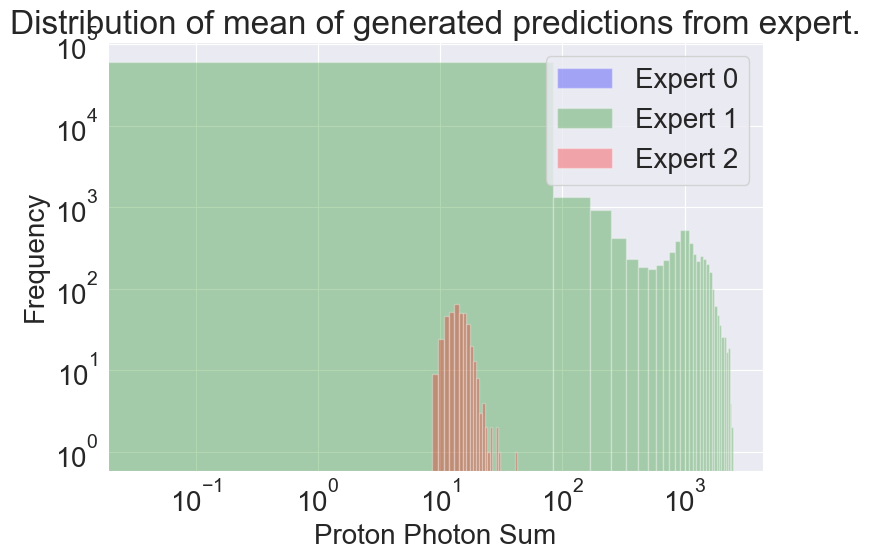

In [66]:
fig = plot_proton_photonsum_histogreams_shared(photonsum_on_all_generated_images_0, photonsum_on_all_generated_images_1, photonsum_on_all_generated_images_2)
fig.show()

#### Generate plots

In [33]:
x_test_0 = x_test[np.where(predicted_expert == 0)[0]]
x_test_1 = x_test[np.where(predicted_expert == 1)[0]]
x_test_2 = x_test[np.where(predicted_expert == 2)[0]]
print(len(x_test_0), len(x_test_1), len(x_test_2))

0 68454 392


In [53]:
# y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
# y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
# y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)
BATCH_SIZE = 128
results_0 = get_predictions_from_generator_results(BATCH_SIZE, len(y_test_0), NOISE_DIM, device, y_test_0_tensor, expert_0)
results_1 = get_predictions_from_generator_results(BATCH_SIZE, len(y_test_1), NOISE_DIM, device, y_test_1_tensor, expert_1)
results_2 = get_predictions_from_generator_results(BATCH_SIZE, len(y_test_2), NOISE_DIM, device, y_test_2_tensor, expert_2)

ch_gen_0 = pd.DataFrame(sum_channels_parallel(results_0)).values if len(results_0) else np.zeros((0, 5))
ch_gen_1 = pd.DataFrame(sum_channels_parallel(results_1)).values if len(results_1) else np.zeros((0, 5))
ch_gen_2 = pd.DataFrame(sum_channels_parallel(results_2)).values if len(results_2) else np.zeros((0, 5))

ch_gen_all = []
ch_gen_all.extend(ch_gen_0.copy())
ch_gen_all.extend(ch_gen_1.copy())
ch_gen_all.extend(ch_gen_2.copy())
ch_gen_all = np.array(ch_gen_all)  # all generated predictions

# CALCULATE DISTRIBUTION OF CHANNELS IN ORIGINAL TEST DATA #
org = np.exp(x_test) - 1
ch_org = np.array(org).reshape(-1, 56, 30)
del org
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values

### Calculate WS

In [74]:
# CALCULATE DISTRIBUTION OF CHANNELS IN ORIGINAL TEST DATA #
org = np.exp(x_test) - 1
ch_org = np.array(org).reshape(-1, 56, 30)
del org
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values

ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2 = calculate_joint_ws_across_experts(1,
                                                                             [x_test_0, x_test_1,x_test_2],
                                                                             [y_test_0, y_test_1, y_test_2],
                                                                             [expert_0, expert_1, expert_2], ch_org,
                                                                             [ch_gen_0, ch_gen_1, ch_gen_2],
                                                                             NOISE_DIM, device,
                                                                             n_experts=N_EXPERTS)

ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2

for generator 1. Samples generated: (16881, 56, 30), real_samples: 16881
for generator 2. Samples generated: (4, 56, 30), real_samples: 4
shape of all generated: (16885, 5)
WS shape of expert 0 (5,)
ws mean 2.01 ch1 0.59 ch2 0.32 ch3 2.20 ch4 4.21 ch5 2.76 

(2.014945264322137,
 1.4377970745482638,
 0.0,
 26.692090846597704,
 0.4953880414366722)

### HISTOGRAM

In [ ]:
ch_gen_all.shape

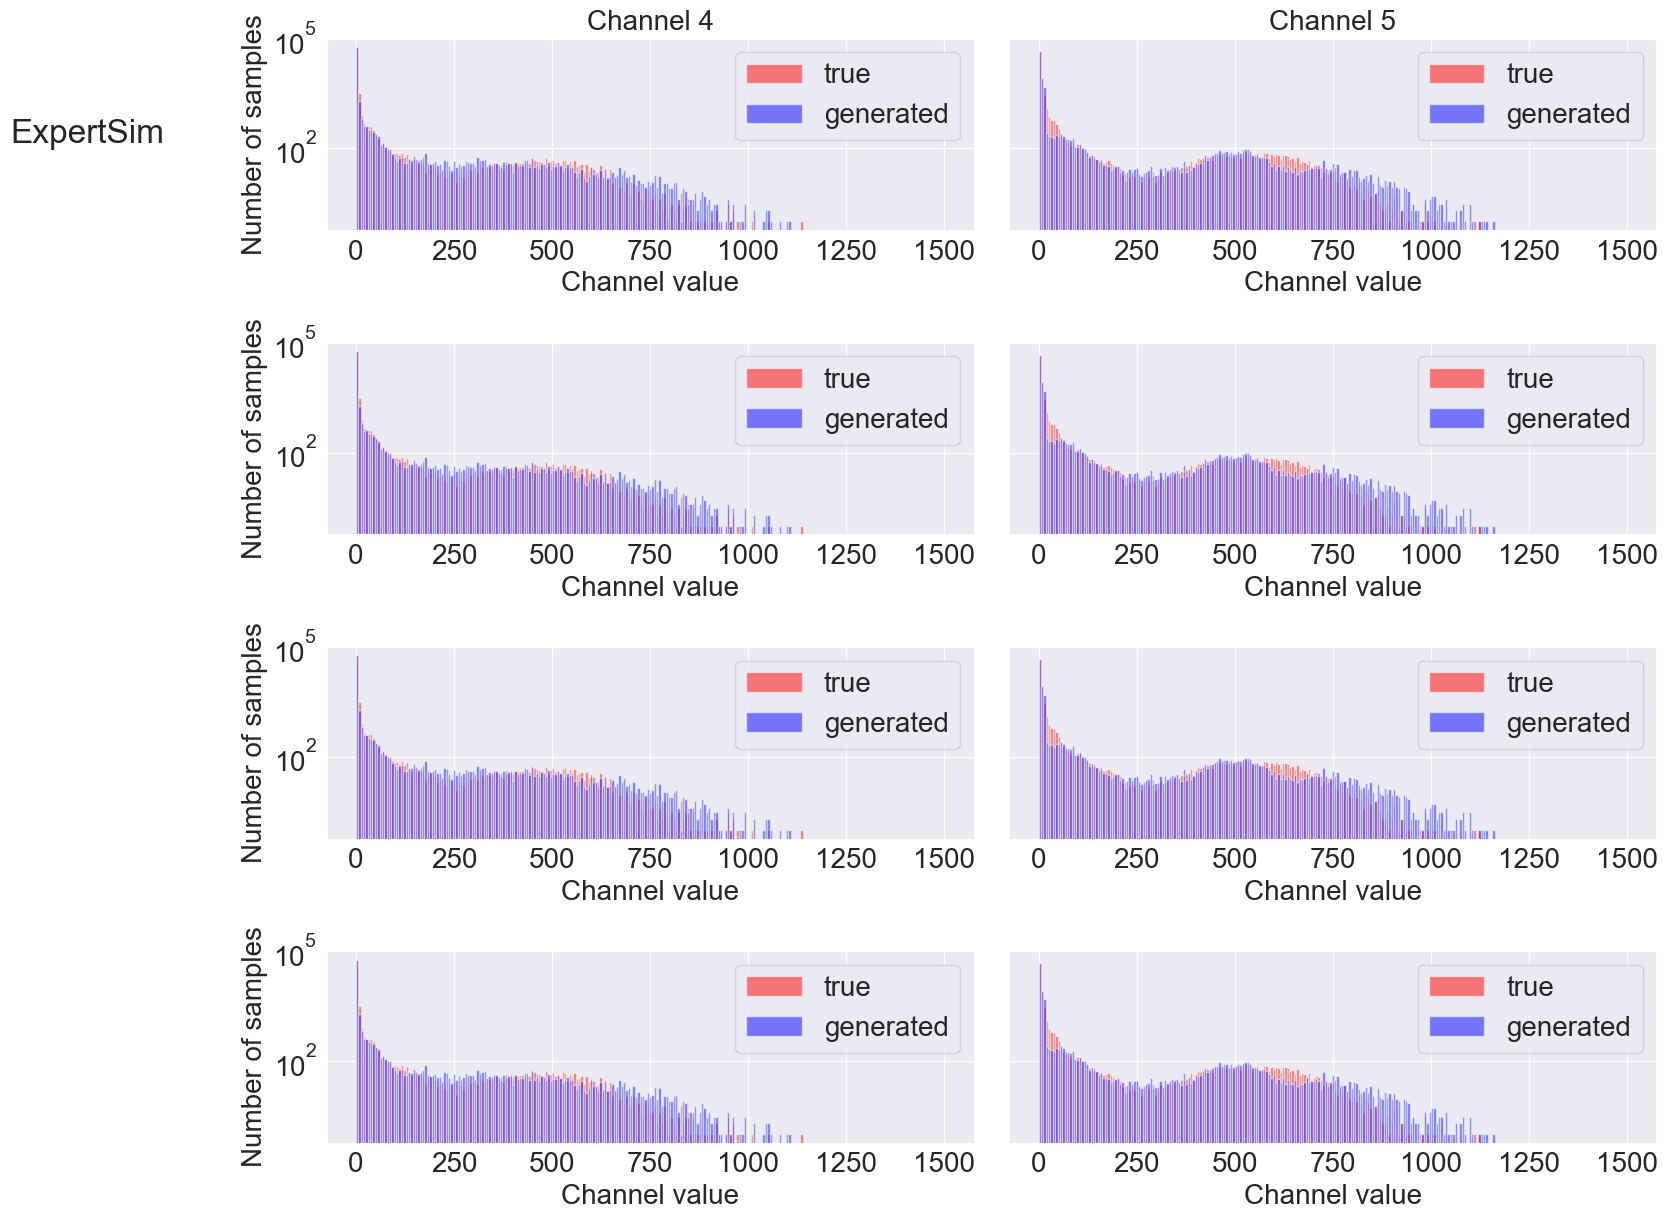

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5

fig, axis = plt.subplots(4, 2, figsize=(16, 14), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=20)
axis[0, 1].set_title('Channel 5', fontsize=20)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([model_moe,model_moe,model_moe,model_moe]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right', fontsize=20)
        if j == 0:
            axis[i][j].set_ylabel('Number of samples', fontsize=20)
        axis[i][j].set_xlabel('Channel value', fontsize=20)
        axis[i][j].set_yscale('log')

plt.xticks(fontsize=20)
fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['ExpertSim']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=24)

fig.savefig(r"C:\Users\PB\Documents\GithubRepos\Generative-DNN-for-Physics-Simulations-CERN\dynamic_neural_networks\pytorch\dynamic_router\plots_aamas\1\histograms_4_5_channels_moe_aamas.png")
plt.show()

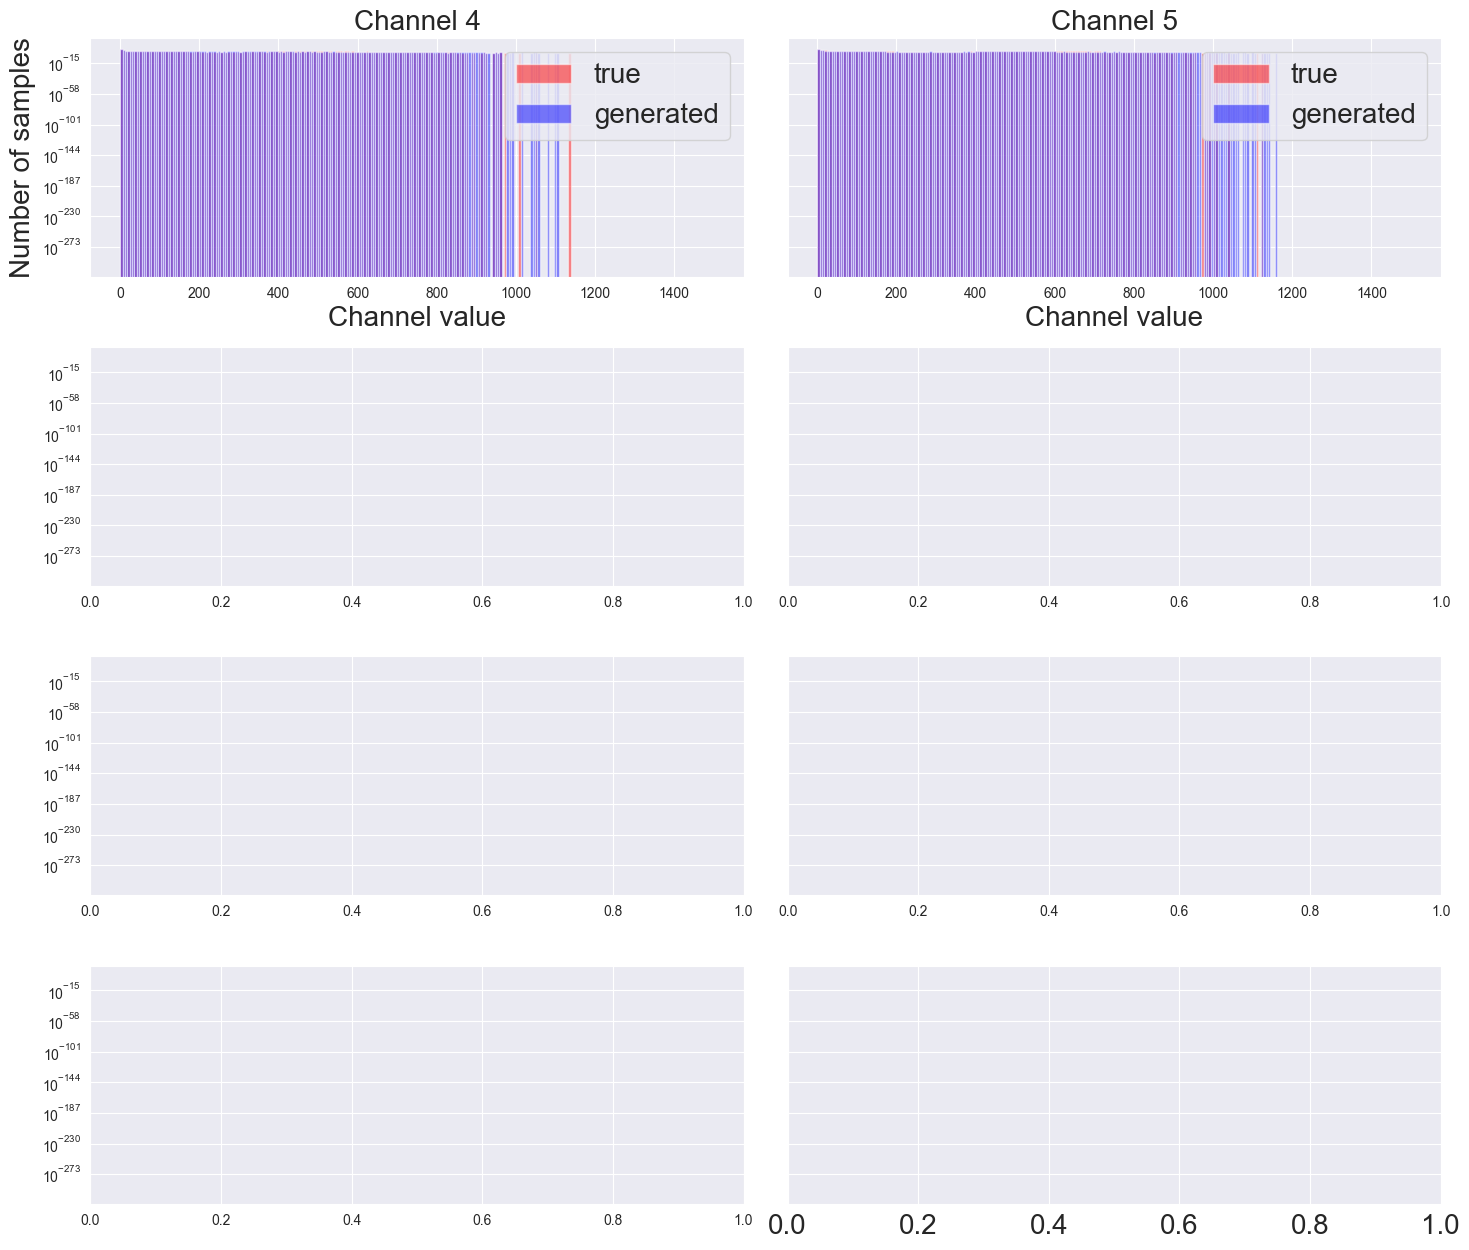

In [16]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
model_moe = ch_gen_all

fig, axis = plt.subplots(4, 2, figsize=(16, 14), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=20)
axis[0, 1].set_title('Channel 5', fontsize=20)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([model_moe]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        # axis[i][j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right', fontsize=20)
        if j == 0:
            axis[i][j].set_ylabel('Number of samples', fontsize=20)
        axis[i][j].set_xlabel('Channel value', fontsize=20)
        axis[i][j].set_yscale('log')

plt.xticks(fontsize=20)
fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

# row_titles = ['ExpertSim']
# for ax, row in zip(axis[:,0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=24)

fig.savefig(r"C:\Users\PB\Documents\GithubRepos\Generative-DNN-for-Physics-Simulations-CERN\dynamic_neural_networks\pytorch\dynamic_router\plots_aamas\1\histograms_4_5_channels_moe_aamas.png")
plt.show()

### EXAMPLES OF SAMPLES GENERATE

In [78]:
import matplotlib.colors as colors

def generate_and_save_images(SAMPLES_IDXs, k, y_test, router_network, experts):
    # produce predictions
    predictions_experts = get_predictions_from_experts_results(len(SAMPLES_IDXs), NOISE_DIM, device, y_test, router_network, experts)

    fig, axs = plt.subplots(2, 7, figsize=(12, 6.4))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, 14):
        if i < 7:
            # Real Neutron
            title_model = "True ZP"
            row = 0
            x = x_test[SAMPLES_IDXs][i % 7].reshape(56, 30)
        elif i >= 7 and i < 14:
            # VAE model
            title_model = "ExpertSim"
            row = 1
            x = predictions_experts[i % 7].reshape(56, 30)

        axs[row, 3].set_title(title_model, fontsize=15)
        im = axs[row, i % 7].imshow(x, cmap='gnuplot')
        axs[row, i % 7].axis('off')
        im_in_row.append(im)

        # add colorbar to the last image, but scale is with respect to the all images in row
        if i % 7 == 6:
            fig.colorbar(im, ax=axs[i // 7, :])

    # plt.tight_layout()
    plt.savefig(f"plots_aamas\\1\\{'_'.join([str(x) for x in SAMPLES_IDXs])}_{k}.png", dpi=300)
    plt.close()

In [81]:
for i in range(0, 30):
    SAMPLES_IDXs = [32029, 44367, 14629, 18671, 23772, 23887, 19571] # [23771, 19719, 23891, 23924 , 23886, 32028, 14628]
    print(i)
    generate_and_save_images(SAMPLES_IDXs, i, y_test[SAMPLES_IDXs], router_network, [expert_0, expert_1, expert_2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


### QUARTILES WS

#### EXPERT MODEL

In [74]:
# save quartile data
# Save individual quartile test data
reference_folder = r"C:\Users\PB\Documents\GithubRepos\Generative-DNN-for-Physics-Simulations-CERN\dynamic_neural_networks\pytorch\dynamic_router\quartile_data"

# Save individual quartile test data
np.save(os.path.join(reference_folder, 'quartile_1_x_test_data.npy'), quartile_1_x_test_data)
np.save(os.path.join(reference_folder, 'quartile_1_y_test_data.npy'), quartile_1_y_test_data)
np.save(os.path.join(reference_folder, 'quartile_2_x_test_data.npy'), quartile_2_x_test_data)
np.save(os.path.join(reference_folder, 'quartile_2_y_test_data.npy'), quartile_2_y_test_data)
np.save(os.path.join(reference_folder, 'quartile_3_x_test_data.npy'), quartile_3_x_test_data)
np.save(os.path.join(reference_folder, 'quartile_3_y_test_data.npy'), quartile_3_y_test_data)
np.save(os.path.join(reference_folder, 'quartile_4_x_test_data.npy'), quartile_4_x_test_data)
np.save(os.path.join(reference_folder, 'quartile_4_y_test_data.npy'), quartile_4_y_test_data)

# Save processed channel data
np.save(os.path.join(reference_folder, 'ch_org_quartile_1.npy'), ch_org_quartile_1)
np.save(os.path.join(reference_folder, 'ch_org_quartile_2.npy'), ch_org_quartile_2)
np.save(os.path.join(reference_folder, 'ch_org_quartile_3.npy'), ch_org_quartile_3)
np.save(os.path.join(reference_folder, 'ch_org_quartile_4.npy'), ch_org_quartile_4)

QUARTILE 1

In [49]:
with torch.no_grad():
    router_network.eval()
    predicted_expert_one_hot = router_network(torch.tensor(quartile_1_y_test_data, device=device)).cpu().numpy()
    predicted_expert = np.argmax(predicted_expert_one_hot, axis=1)

y_test_0 = quartile_1_y_test_data[np.where(predicted_expert == 0)[0].tolist()]
y_test_1 = quartile_1_y_test_data[np.where(predicted_expert == 1)[0].tolist()]
y_test_2 = quartile_1_y_test_data[np.where(predicted_expert == 2)[0].tolist()]
print(len(y_test_0), len(y_test_1), len(y_test_2))

x_test_0 = quartile_1_x_test_data[np.where(predicted_expert == 0)[0]]
x_test_1 = quartile_1_x_test_data[np.where(predicted_expert == 1)[0]]
x_test_2 = quartile_1_x_test_data[np.where(predicted_expert == 2)[0]]
print(len(x_test_0), len(x_test_1), len(x_test_2))

y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)

BATCH_SIZE = 128

# substitute 10 from np.exp(predictions_from_expert)
results_0 = get_predictions_from_generator_results(128, len(y_test_0), NOISE_DIM, device, y_test_0_tensor, expert_0) if len(y_test_0) != 0 else np.zeros((0, 56, 30))
results_1 = get_predictions_from_generator_results(128, len(y_test_1), NOISE_DIM, device, y_test_1_tensor, expert_1) if len(y_test_0) != 0 else np.zeros((0, 56, 30))
results_2 = get_predictions_from_generator_results(128, len(y_test_2), NOISE_DIM, device, y_test_2_tensor, expert_2) if len(y_test_0) != 0 else np.zeros((0, 56, 30))

ch_gen_0 = pd.DataFrame(sum_channels_parallel(results_0)).values if len(results_1) != 0 else np.zeros((0, 5))
ch_gen_1 = pd.DataFrame(sum_channels_parallel(results_1)).values if len(results_1) != 0 else np.zeros((0, 5))
ch_gen_2 = pd.DataFrame(sum_channels_parallel(results_2)).values if len(results_1) != 0 else np.zeros((0, 5))

ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2 = calculate_joint_ws_across_experts(3,
                                                                                     [x_test_0, x_test_1, x_test_2],
                                                                                     [y_test_0, y_test_1, y_test_2],
                                                                                     [expert_0, expert_1, expert_2],
                                                                                     ch_org_quartile_1,
                                                                                     [ch_gen_0, ch_gen_1, ch_gen_2],
                                                                                     NOISE_DIM, device,
                                                                                     n_experts=N_EXPERTS)

ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2

0 22214 235
0 22214 235
for generator 1. Samples generated: (22214, 56, 30), real_samples: 22214
for generator 2. Samples generated: (235, 56, 30), real_samples: 235
shape of all generated: (22449, 5)
for generator 1. Samples generated: (22214, 56, 30), real_samples: 22214
for generator 2. Samples generated: (235, 56, 30), real_samples: 235
shape of all generated: (22449, 5)
for generator 1. Samples generated: (22214, 56, 30), real_samples: 22214
for generator 2. Samples generated: (235, 56, 30), real_samples: 235
shape of all generated: (22449, 5)
WS shape of expert 0 (5,)
ws mean 2.60 ch1 0.43 ch2 0.45 ch3 2.01 ch4 3.37 ch5 6.72 

(2.5968521112710468, 2.336252853021494, 0.0, 0.0, 0.0)

In [44]:
results_1.shape

(0, 56, 30)

2 QUARTILE

In [76]:
with torch.no_grad():
    router_network.eval()
    predicted_expert_one_hot = router_network(torch.tensor(quartile_2_y_test_data, device=device)).cpu().numpy()
    predicted_expert = np.argmax(predicted_expert_one_hot, axis=1)

y_test_0 = quartile_2_y_test_data[np.where(predicted_expert == 0)[0].tolist()]
y_test_1 = quartile_2_y_test_data[np.where(predicted_expert == 1)[0].tolist()]
y_test_2 = quartile_2_y_test_data[np.where(predicted_expert == 2)[0].tolist()]
print(len(y_test_0), len(y_test_1), len(y_test_2))

x_test_0 = quartile_2_x_test_data[np.where(predicted_expert == 0)[0]]
x_test_1 = quartile_2_x_test_data[np.where(predicted_expert == 1)[0]]
x_test_2 = quartile_2_x_test_data[np.where(predicted_expert == 2)[0]]
print(len(x_test_0), len(x_test_1), len(x_test_2))

y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)

BATCH_SIZE = 128

results_0 = get_predictions_from_generator_results(128, len(y_test_0), NOISE_DIM, device, y_test_0_tensor, expert_0) if len(y_test_0) != 0 else np.zeros((0, 56, 30))
results_1 = get_predictions_from_generator_results(128, len(y_test_1), NOISE_DIM, device, y_test_1_tensor, expert_1) if len(y_test_0) != 0 else np.zeros((0, 56, 30))
results_2 = get_predictions_from_generator_results(128, len(y_test_2), NOISE_DIM, device, y_test_2_tensor, expert_2) if len(y_test_0) != 0 else np.zeros((0, 56, 30))

ch_gen_0 = pd.DataFrame(sum_channels_parallel(results_0)).values if len(results_1) != 0 else np.zeros((0, 5))
ch_gen_1 = pd.DataFrame(sum_channels_parallel(results_1)).values if len(results_1) != 0 else np.zeros((0, 5))
ch_gen_2 = pd.DataFrame(sum_channels_parallel(results_2)).values if len(results_1) != 0 else np.zeros((0, 5))

start_time = time.time()
ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2 = calculate_joint_ws_across_experts(3,
                                                                             [x_test_0, x_test_1, x_test_2],
                                                                             [y_test_0, y_test_1, y_test_2],
                                                                             [expert_0, expert_1, expert_2], ch_org_quartile_2,
                                                                             [ch_gen_0, ch_gen_1, ch_gen_2],
                                                                             NOISE_DIM, device,
                                                                             n_experts=N_EXPERTS)
end_time = time.time() - start_time
print(end_time)
ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2

0 11907 116
0 11907 116
for generator 1. Samples generated: (11907, 56, 30), real_samples: 11907
for generator 2. Samples generated: (116, 56, 30), real_samples: 116
shape of all generated: (12023, 5)
for generator 1. Samples generated: (11907, 56, 30), real_samples: 11907
for generator 2. Samples generated: (116, 56, 30), real_samples: 116
shape of all generated: (12023, 5)
for generator 1. Samples generated: (11907, 56, 30), real_samples: 11907
for generator 2. Samples generated: (116, 56, 30), real_samples: 116
shape of all generated: (12023, 5)
WS shape of expert 0 (5,)
ws mean 3.70 ch1 0.46 ch2 0.52 ch3 3.23 ch4 4.99 ch5 9.28 21.098901510238647


(3.6954482309752605, 3.2770201995107646, 0.0, 0.0, 0.0)

In [77]:
end_time

21.098901510238647

3 QUARTILE

In [51]:
with torch.no_grad():
    router_network.eval()
    predicted_expert_one_hot = router_network(torch.tensor(quartile_3_y_test_data, device=device)).cpu().numpy()
    predicted_expert = np.argmax(predicted_expert_one_hot, axis=1)

y_test_0 = quartile_3_y_test_data[np.where(predicted_expert == 0)[0].tolist()]
y_test_1 = quartile_3_y_test_data[np.where(predicted_expert == 1)[0].tolist()]
y_test_2 = quartile_3_y_test_data[np.where(predicted_expert == 2)[0].tolist()]
print(len(y_test_0), len(y_test_1), len(y_test_2))

x_test_0 = quartile_3_x_test_data[np.where(predicted_expert == 0)[0]]
x_test_1 = quartile_3_x_test_data[np.where(predicted_expert == 1)[0]]
x_test_2 = quartile_3_x_test_data[np.where(predicted_expert == 2)[0]]
print(len(x_test_0), len(x_test_1), len(x_test_2))

y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)

BATCH_SIZE = 128

results_0 = get_predictions_from_generator_results(128, len(y_test_0), NOISE_DIM, device, y_test_0_tensor, expert_0) if len(y_test_0) != 0 else np.zeros((0, 56, 30))
results_1 = get_predictions_from_generator_results(128, len(y_test_1), NOISE_DIM, device, y_test_1_tensor, expert_1) if len(y_test_0) != 0 else np.zeros((0, 56, 30))
results_2 = get_predictions_from_generator_results(128, len(y_test_2), NOISE_DIM, device, y_test_2_tensor, expert_2) if len(y_test_0) != 0 else np.zeros((0, 56, 30))

ch_gen_0 = pd.DataFrame(sum_channels_parallel(results_0)).values if len(results_1) != 0 else np.zeros((0, 5))
ch_gen_1 = pd.DataFrame(sum_channels_parallel(results_1)).values if len(results_1) != 0 else np.zeros((0, 5))
ch_gen_2 = pd.DataFrame(sum_channels_parallel(results_2)).values if len(results_1) != 0 else np.zeros((0, 5))

ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2 = calculate_joint_ws_across_experts(3,
                                                                             [x_test_0, x_test_1, x_test_2],
                                                                             [y_test_0, y_test_1, y_test_2],
                                                                             [expert_0, expert_1, expert_2], ch_org_quartile_3,
                                                                             [ch_gen_0, ch_gen_1, ch_gen_2],
                                                                             NOISE_DIM, device,
                                                                             n_experts=N_EXPERTS)

ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2

0 17452 37
0 17452 37
for generator 1. Samples generated: (17452, 56, 30), real_samples: 17452
for generator 2. Samples generated: (37, 56, 30), real_samples: 37
shape of all generated: (17489, 5)
for generator 1. Samples generated: (17452, 56, 30), real_samples: 17452
for generator 2. Samples generated: (37, 56, 30), real_samples: 37
shape of all generated: (17489, 5)
for generator 1. Samples generated: (17452, 56, 30), real_samples: 17452
for generator 2. Samples generated: (37, 56, 30), real_samples: 37
shape of all generated: (17489, 5)
WS shape of expert 0 (5,)
ws mean 3.27 ch1 0.35 ch2 0.26 ch3 3.27 ch4 4.60 ch5 7.89 

(3.2732942706118493, 2.853279702397421, 0.0, 0.0, 0.0)

4 QUARTILE

In [52]:
with torch.no_grad():
    router_network.eval()
    predicted_expert_one_hot = router_network(torch.tensor(quartile_4_y_test_data, device=device)).cpu().numpy()
    predicted_expert = np.argmax(predicted_expert_one_hot, axis=1)

y_test_0 = quartile_4_y_test_data[np.where(predicted_expert == 0)[0].tolist()]
y_test_1 = quartile_4_y_test_data[np.where(predicted_expert == 1)[0].tolist()]
y_test_2 = quartile_4_y_test_data[np.where(predicted_expert == 2)[0].tolist()]
print(len(y_test_0), len(y_test_1), len(y_test_2))

x_test_0 = quartile_4_x_test_data[np.where(predicted_expert == 0)[0]]
x_test_1 = quartile_4_x_test_data[np.where(predicted_expert == 1)[0]]
x_test_2 = quartile_4_x_test_data[np.where(predicted_expert == 2)[0]]
print(len(x_test_0), len(x_test_1), len(x_test_2))

y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)

BATCH_SIZE = 128

results_0 = get_predictions_from_generator_results(128, len(y_test_0), NOISE_DIM, device, y_test_0_tensor, expert_0) if len(y_test_0) != 0 else np.zeros((0, 56, 30))
results_1 = get_predictions_from_generator_results(128, len(y_test_1), NOISE_DIM, device, y_test_1_tensor, expert_1) if len(y_test_0) != 0 else np.zeros((0, 56, 30))
results_2 = get_predictions_from_generator_results(128, len(y_test_2), NOISE_DIM, device, y_test_2_tensor, expert_2) if len(y_test_0) != 0 else np.zeros((0, 56, 30))

ch_gen_0 = pd.DataFrame(sum_channels_parallel(results_0)).values if len(results_1) != 0 else np.zeros((0, 5))
ch_gen_1 = pd.DataFrame(sum_channels_parallel(results_1)).values if len(results_1) != 0 else np.zeros((0, 5))
ch_gen_2 = pd.DataFrame(sum_channels_parallel(results_2)).values if len(results_1) != 0 else np.zeros((0, 5))

ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2 = calculate_joint_ws_across_experts(3,
                                                                             [x_test_0, x_test_1, x_test_2],
                                                                             [y_test_0, y_test_1, y_test_2],
                                                                             [expert_0, expert_1, expert_2], ch_org_quartile_4,
                                                                             [ch_gen_0, ch_gen_1, ch_gen_2],
                                                                             NOISE_DIM, device,
                                                                             n_experts=N_EXPERTS)

ws_mean, ws_std, ws_mean_0, ws_mean_1, ws_mean_2

0 16881 4
0 16881 4
for generator 1. Samples generated: (16881, 56, 30), real_samples: 16881
for generator 2. Samples generated: (4, 56, 30), real_samples: 4
shape of all generated: (16885, 5)
for generator 1. Samples generated: (16881, 56, 30), real_samples: 16881
for generator 2. Samples generated: (4, 56, 30), real_samples: 4
shape of all generated: (16885, 5)
for generator 1. Samples generated: (16881, 56, 30), real_samples: 16881
for generator 2. Samples generated: (4, 56, 30), real_samples: 4
shape of all generated: (16885, 5)
WS shape of expert 0 (5,)
ws mean 22.67 ch1 4.23 ch2 2.41 ch3 25.00 ch4 23.19 ch5 58.50 

(22.665555603613846, 20.19665441646316, 0.0, 0.0, 0.0)

#### LOAD rest models

# Model based on routers - STRAT BATCH THE BEST 1.85 WS

## Analyze routers

#### Best router with ws ~ 2.09 based on the equal class batch sampling and router helper

In [ ]:
y_test_tensor = torch.tensor(y_test_, requires_grad=False, device=device)

In [ ]:
N_EXPERTS = 3
N_COND = 9
router_network = RouterNetwork(N_COND, N_EXPERTS).to(device)
router_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX3E94~1\3_D77D~1.001\models\router_network_epoch_100.pth"
router_network.load_state_dict(torch.load(router_weights))

with torch.no_grad():
    router_network.eval()
    predicted_expert_one_hot = router_network(y_test_tensor).cpu().numpy()
    predicted_expert = np.argmax(predicted_expert_one_hot, axis=1)

In [ ]:
x_test_0 = x_test[np.where(predicted_expert == 0)[0]]
x_test_1 = x_test[np.where(predicted_expert == 1)[0]]
x_test_2 = x_test[np.where(predicted_expert == 2)[0]]
print(len(x_test_0), len(x_test_1), len(x_test_2))

In [ ]:
expert_counts = np.unique(predicted_expert,  return_counts=True)
expert_number_count_dict = {expert_number: expert_count for (expert_number, expert_count) in zip(expert_counts[0], expert_counts[1])}

In [ ]:
expert_number_count_dict

In [ ]:
# Assuming data_cond is your DataFrame and proton_photon_sum is a column in it
data_cond.proton_photon_sum.hist(bins=30, alpha=0.7, color='blue')  # Adjust bins, alpha, and color as needed

# Set the x and y axis to logarithmic scale
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.yscale('log')  # Set y-axis to logarithmic scale

In [ ]:
data_cond_temp = data_cond.iloc[idx_test].reset_index(drop=True)

In [ ]:
data_cond_0 = data_cond_temp.iloc[np.where(predicted_expert == 0)[0].tolist()]
data_cond_1 = data_cond_temp.iloc[np.where(predicted_expert == 1)[0].tolist()]
data_cond_2 = data_cond_temp.iloc[np.where(predicted_expert == 2)[0].tolist()]
len(data_cond_0), len(data_cond_1), len(data_cond_2)

In [ ]:
fig = plot_proton_photonsum_histogreams_shared(data_cond_0.proton_photon_sum, data_cond_1.proton_photon_sum, data_cond_2.proton_photon_sum)
fig.show()

In [ ]:
fig = plot_proton_photonsum_histogreams(data_cond_0.proton_photon_sum, data_cond_1.proton_photon_sum, data_cond_2.proton_photon_sum)
fig.show()

In [ ]:
data_cond_0.proton_photon_sum.mean(), data_cond_1.proton_photon_sum.mean(), data_cond_2.proton_photon_sum.mean()

### Load models of experts

In [ ]:
NOISE_DIM = 10
N_COND = 9
DI_STRENGTH, IN_STRENGTH = 0.1, 0.0001

In [ ]:
############ EXPERT 0 ###############
expert_0 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
expert_0_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX1D62~1\3_D77D~1.001\models\gen_0_91.h5"
expert_0.load_state_dict(torch.load(expert_0_weights))

############ EXPERT 1 ###############
expert_1 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
expert_1_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX1D62~1\3_D77D~1.001\models\gen_1_91.h5"
expert_1.load_state_dict(torch.load(expert_1_weights))

############ EXPERT 2 ###############
expert_2 = Generator(NOISE_DIM, N_COND, DI_STRENGTH, IN_STRENGTH).to(device)
expert_2_weights = r"C:\Users\PB\DOCUME~1\GITHUB~1\GENERA~2\DYNAMI~1\pytorch\DYNAMI~1\EX1D62~1\3_D77D~1.001\models\gen_2_91.h5"
expert_2.load_state_dict(torch.load(expert_2_weights))


#### Generate MEAN and STD of the experts on the test data

In [ ]:
# data_cond_scaled_temp = data_cond.iloc[idx_test]
# y_test_0 = data_cond_scaled_temp.iloc[np.where(predicted_expert == 0)[0].tolist()]
# y_test_1 = data_cond_scaled_temp.iloc[np.where(predicted_expert == 1)[0].tolist()]
# y_test_2 = data_cond_scaled_temp.iloc[np.where(predicted_expert == 2)[0].tolist()]
# print(len(y_test_0), len(y_test_1), len(y_test_2))
#
# y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
# y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
# y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)

In [ ]:
# y_test_0.reset_index(drop=True).proton_photon_sum # 53, 143, 197, 331, 403, 445, 481

In [ ]:
data_cond_scaled_temp = data_cond_scaled[idx_test]
y_test_0 = data_cond_scaled_temp[np.where(predicted_expert == 0)[0].tolist()]
y_test_1 = data_cond_scaled_temp[np.where(predicted_expert == 1)[0].tolist()]
y_test_2 = data_cond_scaled_temp[np.where(predicted_expert == 2)[0].tolist()]
print(len(y_test_0), len(y_test_1), len(y_test_2))

y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)

In [ ]:
############ EXPERT 0 ###############
noise_cond_0 = y_test_0_tensor
photonsum_mean_generated_images_0, photonsum_std_generated_images_0, photonsum_on_all_generated_images_0 = get_mean_std_from_expert_genrations(noise_cond_0, expert_0, device, batch_size=256, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_0, photonsum_std_generated_images_0

In [ ]:
############ EXPERT 1 ###############
noise_cond_1 = y_test_1_tensor
photonsum_mean_generated_images_1, photonsum_std_generated_images_1, photonsum_on_all_generated_images_1 = get_mean_std_from_expert_genrations(noise_cond_1, expert_1, device, batch_size=256, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_1, photonsum_std_generated_images_1

In [ ]:
############ EXPERT 2 ###############
noise_cond_2 = y_test_2_tensor
photonsum_mean_generated_images_2, photonsum_std_generated_images_2, photonsum_on_all_generated_images_2 = get_mean_std_from_expert_genrations(noise_cond_2, expert_2, device, batch_size=256, noise_dim=NOISE_DIM)
photonsum_mean_generated_images_2, photonsum_std_generated_images_2

In [ ]:
fig = plot_proton_photonsum_histogreams_shared(photonsum_on_all_generated_images_0, photonsum_on_all_generated_images_1, photonsum_on_all_generated_images_2)
fig.show()

Get histogram

In [ ]:
y_test_0_tensor = torch.tensor(y_test_0, requires_grad=False, device=device)
y_test_1_tensor = torch.tensor(y_test_1, requires_grad=False, device=device)
y_test_2_tensor = torch.tensor(y_test_2, requires_grad=False, device=device)
BATCH_SIZE = 128
results_0 = get_predictions_from_generator_results(128, len(y_test_0), NOISE_DIM, device, y_test_0_tensor, expert_0)
results_1 = get_predictions_from_generator_results(128, len(y_test_1), NOISE_DIM, device, y_test_1_tensor, expert_1)
results_2 = get_predictions_from_generator_results(128, len(y_test_2), NOISE_DIM, device, y_test_2_tensor, expert_2)

ch_gen_0 = pd.DataFrame(sum_channels_parallel(results_0)).values
ch_gen_1 = pd.DataFrame(sum_channels_parallel(results_1)).values
ch_gen_2 = pd.DataFrame(sum_channels_parallel(results_2)).values

ch_gen_all = []
ch_gen_all.extend(ch_gen_0.copy())
ch_gen_all.extend(ch_gen_1.copy())
ch_gen_all.extend(ch_gen_2.copy())
ch_gen_all = np.array(ch_gen_all)  # all generated predictions

# CALCULATE DISTRIBUTION OF CHANNELS IN ORIGINAL TEST DATA #
org = np.exp(x_test) - 1
ch_org = np.array(org).reshape(-1, 56, 30)
del org
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values

fig, axis = plt.subplots(5, 1, figsize=(10, 14), sharex=False, sharey=False)
fig.suptitle("TEST", x=0.1, horizontalalignment='left')

for i in range(5):
    bins = np.linspace(0, 1500, 250)
    axis[i].set_title("Kanał " + str(i + 1))
    axis[i].hist(ch_org[:, i], bins, alpha=0.5, label='true', color="red")
    axis[i].hist(ch_gen_all[:, i], bins, alpha=0.5, label='generated', color="blue")
    axis[i].legend(loc='upper right')
    axis[i].set_ylabel('Liczba przykładów')
    axis[i].set_xlabel('Wartość kanału')
    axis[i].set_yscale('log')

fig.tight_layout(rect=[0, 0, 1, 0.975])
# fig.savefig("hist_orig.png")
plt.show()

### CALCULATE WS ###

In [ ]:
ws_mean, ws_mean_0, ws_mean_1, ws_mean_2 = calculate_joint_ws_across_experts(1,
                                                                             [x_test_0,x_test_1,x_test_2],
                                                                             [y_test_0, y_test_1, y_test_2],
                                                                                         [expert_0, expert_1, expert_2], ch_org,
                                                                                         [ch_gen_0, ch_gen_1, ch_gen_2],
                                                                                         NOISE_DIM, device,
                                                                                         n_experts=N_EXPERTS)



In [ ]:
ws_mean, ws_mean_0, ws_mean_1, ws_mean_2